In [1]:
import numpy as np
from numpy import *
import swift_scrape
import os
import matplotlib.pyplot as plt
from matplotlib import ticker
import lmfit as lm

In [3]:
GRBs=["050724","060614", "061210", "070714B", "071227", "150424A","211211A","211227A", "051227","061006","080123","080503","090531B","111121A"]

swift_scrape.get_targetIDs(save=True)

for grb in GRBs:
    swift_scrape.get_xrt(grb,keep=True)

Local file found for 050724
Local file found for 060614
Local file found for 061210
Local file found for 070714B
Local file found for 071227
Local file found for 150424A
Local file found for 211211A
Local file found for 211227A
Local file found for 051227
Local file found for 061006
Local file found for 080123
Local file found for 080503
Local file found for 090531B
Local file found for 111121A


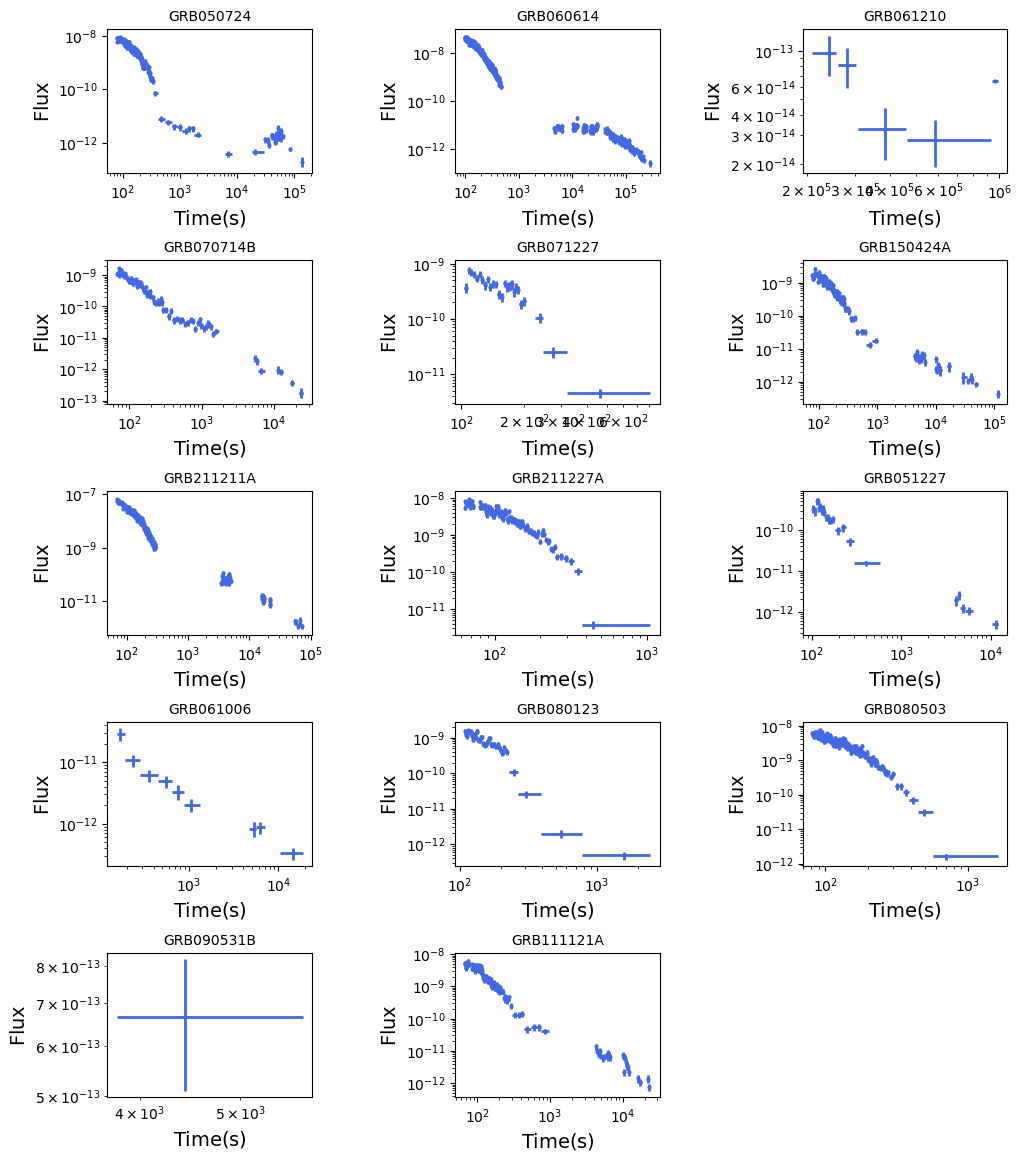

In [11]:
folder='./afterglow_data/'
filename='_xray_flux.txt'
GRBs=["050724","060614", "061210", "070714B", "071227", "150424A","211211A","211227A", "051227","061006","080123","080503","090531B","111121A"]


##################################################################################
fig=plt.figure(figsize=(10.0,12.0), dpi=100)
fig.patch.set_facecolor('white')
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.7)

for i in range(len(GRBs)):
    ax1 = fig.add_subplot(5, 3, i+1)
    Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
    ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    #ax1.set_xlim(1e1,1e5)
    #ax1.set_ylim(1e-14,1e-9)
    ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
    ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
    ax1.set_title("GRB"+GRBs[i],fontsize=10)

#xticks = ticker.LogLocator(numticks=4)
#ax1.xaxis.set_minor_locator(xticks)
#ax1.tick_params(axis='x', which='minor', labelsize=7.0)

plt.show()

### Scipy Minimize + MCMC fine-tuning

In [13]:
def MCMC_fitting(time,lumin,err_tot,name, tbreak_limits, alpha1_limits, alpha2_limits, amp_limits):
    t_break_true,alpha_1_true,alpha_2_true,amplitude_true=mean(tbreak_limits),mean(alpha1_limits),mean(alpha2_limits),mean(amp_limits)
    nll = lambda *args: -lnlike(*args)

    time=array(time)
    lumin=array(lumin)
    err_tot=array(err_tot)

    result = op.minimize(nll, [t_break_true,alpha_1_true,alpha_2_true,amplitude_true], args=(time,lumin,err_tot))
    t_break_ml,alpha_1_ml,alpha_2_ml,amplitude_ml = result["x"]

    ndim, nwalkers = 4, 128
    p0 = [result["x"] + [t_break_true,alpha_1_true,alpha_2_true,amplitude_true]*random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(time,lumin,err_tot))
    pos, _, _ = sampler.run_mcmc(p0, 1000)
    sampler.reset()
    sampler.run_mcmc(pos, 10000)
    
    samples = sampler.flatchain
    theta_max  = samples[argmax(sampler.flatlnprobability)]

    fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
#   samples = sampler.get_chain()
    labels = ["$t_{break}$", "$\\tau_1$", "$\\tau_2$", "$A$"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, i], "k", alpha=0.9)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    plt.savefig('GRB'+ name+'/'+name+'_running.pdf',format='pdf')
    plt.close()
    
    samples[:, 1] = (samples[:, 1])
    t_break_mcmc,alpha_1_mcmc,alpha_2_mcmc,amplitude_mcmc = map(lambda q: (q[1], q[0], q[2]),zip(*percentile(samples, [16, 50, 84],axis=0)))

    fig = corner.corner(samples, labels=["$t_{break}$", "$\\tau_1$", "$\\tau_2$", "$A$"], quantiles=[0.16, 0.5, 0.84],color='indigo',
                        linewidth=4.0,show_titles=True,plot_datapoints=False,fill_contours=True,bins=80, smooth=1.0)
    plt.savefig('GRB'+ name+'/'+name+'_corner.pdf',format='pdf')
    plt.close()
    
    return t_break_mcmc,alpha_1_mcmc,alpha_2_mcmc,amplitude_mcmc

/Users/kruthik/opt/miniconda3/envs/fxt/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


T_break: 179.8613193851153 min: -57.6024736259036 max: 366.7473237038991
alpha1: -2.144710872216683 min: -4.1026164356486134 max: 0.16720334531647987
alpha2: 5.4522459016019 min: 0.5365250345811035 max 11.64916318619333
A: 4.677178804857515e-10 min: 5.4356921995961055e-12 max: 1.0289421192382714e-09
MCMC results - R squared: 0.426, p-value: 4.28e-02
Guessing - R squared: 0.805, p-value: 3.54e-06


118.636

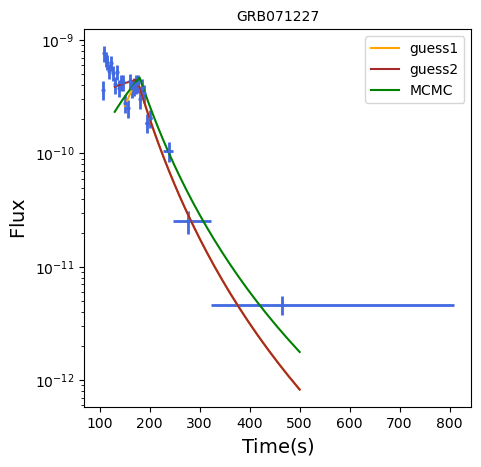

In [17]:
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
fig.patch.set_facecolor('white')

i=7
ax1 = fig.add_subplot(1, 1, 1)
Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
#plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
#ax1.set_xlim(1e1,3e2)
#ax1.set_ylim(1e-14,1e-9)
ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
ax1.set_title("GRB"+GRBs[i],fontsize=10)

tbreak_lim = (100,300)
alph1_lim = (-5,0.5)
alph2_lim = (3,9)
amp_lim = (1e-10,1e-9)
t_break_mcmc,alpha_1_mcmc,alpha_2_mcmc,amplitude_mcmc=MCMC_fitting(Time[5:],Flux[5:],Flux_low[5:],GRBs[i],tbreak_lim,alph1_lim,alph2_lim,amp_lim)

x1=np.geomspace(150,500,30)
x2=np.geomspace(130,500,30)
ax1.plot(x1,broken_power_law(x1,175,-3.5,6,4.5e-10),color='orange',label='guess1')
ax1.plot(x2,broken_power_law(x2,175,-0.5,6,4.5e-10),color='brown',label='guess2')
#ax1.text(1e2,1e-12,"T_break: {:.1e} \n tau_1:{:.1e}\n tau_2:{:.1e} \n F0(erg/cm^2-s):{:.1e}".format(175,-3.5,6,4.5e-10))
ax1.plot(x2,broken_power_law(x2,t_break_mcmc[0],alpha_1_mcmc[0],alpha_2_mcmc[0],amplitude_mcmc[0]),color='green',label='MCMC')
ax1.legend()

print('T_break:',t_break_mcmc[0],'min:',t_break_mcmc[1],'max:',t_break_mcmc[2])
print('alpha1:',alpha_1_mcmc[0],'min:',alpha_1_mcmc[1],'max:',alpha_1_mcmc[2])
print('alpha2:',alpha_2_mcmc[0],'min:',alpha_2_mcmc[1],'max',alpha_2_mcmc[2])
print('A:',amplitude_mcmc[0],'min:',amplitude_mcmc[1],'max:',amplitude_mcmc[2])


flux_fit = broken_power_law(np.array(Time[5:]),t_break_mcmc[0],alpha_1_mcmc[0],alpha_2_mcmc[0],amplitude_mcmc[0])
_,_, r_value, p_value, std_err = scipy.stats.linregress(Flux[5:],flux_fit)
print("MCMC results - R squared: {:.3f}, p-value: {:.2e}".format(r_value,p_value))

flux_fit = broken_power_law(np.array(Time[5:]),175,-0.5,6,4.5e-10)
_,_, r_value, p_value, std_err = scipy.stats.linregress(Flux[5:],flux_fit)
print("Guessing - R squared: {:.3f}, p-value: {:.2e}".format(r_value,p_value))

Time[5]

/Users/kruthik/opt/miniconda3/envs/fxt/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


T_break: 2881.8028197873555 min: 1044.3997052249351 max: 3777.035106464703
alpha1: 0.19369169163603417 min: -0.1337026203512652 max: 0.19903397485571384
alpha2: 2.2380636830147327 min: 1.268366926320531 max 3.128247020542478
A: 9.990479375882641e-12 min: 9.913131267891388e-12 max: 1.0870572204318118e-10
MCMC results - R squared: 0.624, p-value: 6.03e-06
Guessing - R squared: 0.365, p-value: 1.50e-02


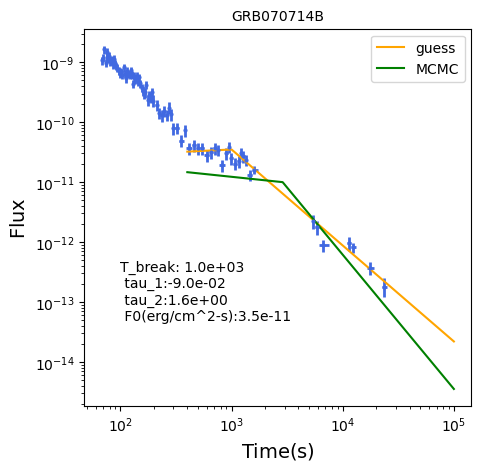

In [21]:
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
fig.patch.set_facecolor('white')

i=2
ax1 = fig.add_subplot(1,1,1)
Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
#ax1.set_xlim(1e1,1e5)
#ax1.set_ylim(1e-14,1e-9)
ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
ax1.set_title("GRB"+GRBs[i],fontsize=10)

tbreak_lim = (5e2,5e3)
alph1_lim = (-0.2,0)
alph2_lim = (0,3.0)
amp_lim = (1e-11,1e-10)
t_break_mcmc,alpha_1_mcmc,alpha_2_mcmc,amplitude_mcmc=MCMC_fitting(Time[5:],Flux[5:],Flux_low[5:],GRBs[i],tbreak_lim,alph1_lim,alph2_lim,amp_lim)

x=arange(4e2,1e5,10)
ax1.plot(x,broken_power_law(x,1e3,-0.09,1.6,3.5e-11),color='orange',label='guess')
ax1.plot(x,broken_power_law(x,t_break_mcmc[0],alpha_1_mcmc[0],alpha_2_mcmc[0],amplitude_mcmc[0]),color='green',label='MCMC')
ax1.text(1e2,5e-14,"T_break: {:.1e} \n tau_1:{:.1e}\n tau_2:{:.1e} \n F0(erg/cm^2-s):{:.1e}".format(1e3,-0.09,1.6,3.5e-11))
ax1.legend()

print('T_break:',t_break_mcmc[0],'min:',t_break_mcmc[1],'max:',t_break_mcmc[2])
print('alpha1:',alpha_1_mcmc[0],'min:',alpha_1_mcmc[1],'max:',alpha_1_mcmc[2])
print('alpha2:',alpha_2_mcmc[0],'min:',alpha_2_mcmc[1],'max',alpha_2_mcmc[2])
print('A:',amplitude_mcmc[0],'min:',amplitude_mcmc[1],'max:',amplitude_mcmc[2])

flux_fit = broken_power_law(np.array(Time[40:]),t_break_mcmc[0],alpha_1_mcmc[0],alpha_2_mcmc[0],amplitude_mcmc[0])
_,_, r_value, p_value, std_err = scipy.stats.linregress(Flux[40:],flux_fit)
print("MCMC results - R squared: {:.3f}, p-value: {:.2e}".format(r_value,p_value))

flux_fit = broken_power_law(np.array(Time[40:]),1e3,-0.09,1.6,3.5e-11)
_,_, r_value, p_value, std_err = scipy.stats.linregress(Flux[40:],flux_fit)
print("Guessing - R squared: {:.3f}, p-value: {:.2e}".format(r_value,p_value))

/Users/kruthik/opt/miniconda3/envs/fxt/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


T_break: 9991.183370898387 min: 9900.785500514547 max: 113996.21714017645
alpha1: -0.43067517400922134 min: -0.5859983040684549 max: -0.11933466429869591
alpha2: 0.8714168517356616 min: 0.8370120678851697 max 2.0777542168000203
A: 9.928853206624872e-12 min: 2.884704139604299e-12 max: 9.996942525449616e-12
MCMC results - R squared: 0.825, p-value: 3.11e-35
Guessing - R squared: 0.870, p-value: 2.34e-43


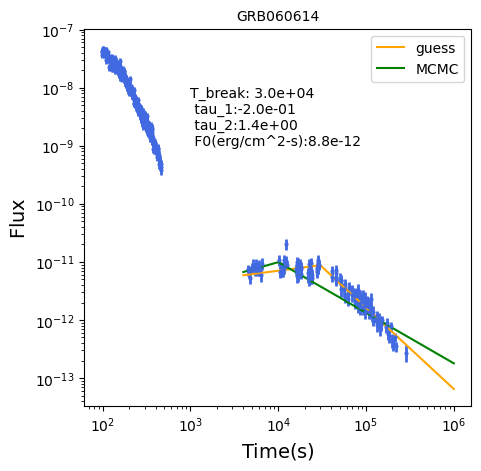

In [16]:
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
fig.patch.set_facecolor('white')

i=1
ax1 = fig.add_subplot(1, 1, 1)
Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
#ax1.set_xlim(1e1,1e5)
#ax1.set_ylim(1e-14,1e-9)
ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
ax1.set_title("GRB"+GRBs[i],fontsize=10)


tbreak_lim = (1e4,1e5)
alph1_lim = (-0.5,0)
alph2_lim = (1.0,2.0)
amp_lim = (1e-12,1e-11)
t_break_mcmc,alpha_1_mcmc,alpha_2_mcmc,amplitude_mcmc=MCMC_fitting(Time[358:],Flux[358:],Flux_low[358:],GRBs[i],tbreak_lim,alph1_lim,alph2_lim,amp_lim)

x=arange(4e3,1e6,10)
ax1.plot(x,broken_power_law(x,3e4,-0.2,1.4,8.8e-12),color='orange',label='guess',zorder=2.0)
ax1.text(1e3,1e-9,"T_break: {:.1e} \n tau_1:{:.1e}\n tau_2:{:.1e} \n F0(erg/cm^2-s):{:.1e}".format(3e4,-0.2,1.4,8.8e-12))
ax1.plot(x,broken_power_law(x,t_break_mcmc[0],alpha_1_mcmc[0],alpha_2_mcmc[0],amplitude_mcmc[0]),color='green',label='MCMC')
ax1.legend()

print('T_break:',t_break_mcmc[0],'min:',t_break_mcmc[1],'max:',t_break_mcmc[2])
print('alpha1:',alpha_1_mcmc[0],'min:',alpha_1_mcmc[1],'max:',alpha_1_mcmc[2])
print('alpha2:',alpha_2_mcmc[0],'min:',alpha_2_mcmc[1],'max',alpha_2_mcmc[2])
print('A:',amplitude_mcmc[0],'min:',amplitude_mcmc[1],'max:',amplitude_mcmc[2])


flux_fit = broken_power_law(np.array(Time[358:]),t_break_mcmc[0],alpha_1_mcmc[0],alpha_2_mcmc[0],amplitude_mcmc[0])
_,_, r_value, p_value, std_err = scipy.stats.linregress(Flux[358:],flux_fit)
print("MCMC results - R squared: {:.3f}, p-value: {:.2e}".format(r_value,p_value))

flux_fit = broken_power_law(np.array(Time[358:]),3e4,-0.2,1.4,8.8e-12)
_,_, r_value, p_value, std_err = scipy.stats.linregress(Flux[358:],flux_fit)
print("Guessing - R squared: {:.3f}, p-value: {:.2e}".format(r_value,p_value))

### Use lm model fit

[[Model]]
    Model(broken_power_law)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 137
    # variables        = 4
    chi-square         = 1.3268e-44
    reduced chi-square = 9.9759e-47
    Akaike info crit   = -14507.2820
    Bayesian info crit = -14495.6021
[[Variables]]
    t_break:    33145.9411 +/- 9816.23005 (29.62%) (init = 30000)
    alpha_1:   -8.8950e-11 +/- 0.02103106 (23643581609.94%) (init = -0.2)
    alpha_2:    1.49425597 +/- 1.03419788 (69.21%) (init = 1.4)
    amplitude:  9.3647e-12 +/- 6.0884e-13 (6.50%) (init = 8.8e-12)
[[Correlations]] (unreported correlations are < 0.100)
    C(t_break, alpha_2)   = 0.883
    C(alpha_1, amplitude) = 0.842
    C(t_break, amplitude) = -0.147
    C(t_break, alpha_1)   = -0.124


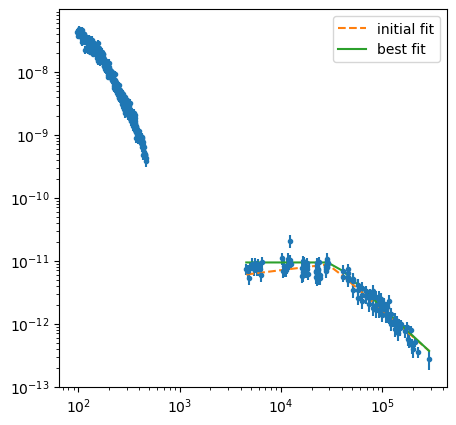

In [10]:
i=1
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)

fit_index = 358
flux_err = [flux_high[i]+flux_low[i] for i in range(len(flux))]

bpl_model = lm.Model(broken_power_law)
bpl_model.set_param_hint("t_break", min = 1e4, max = 1e5, value = 3e4)
bpl_model.set_param_hint("alpha_1", min = -0.5, max = 0, value = -0.2)
bpl_model.set_param_hint("alpha_2", min = 1.0, max = 2.0, value = 1.4)
bpl_model.set_param_hint("amplitude", min = 1e-12, max = 1e-11, value = 8.8e-12)
params = bpl_model.make_params()
result = bpl_model.fit(flux[fit_index:], x = time[fit_index:], weights=flux_err[fit_index:])

print(result.fit_report())

fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(time[fit_index:], result.init_fit, '--', label='initial fit')
plt.plot(time[fit_index:], result.best_fit, '-', label='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

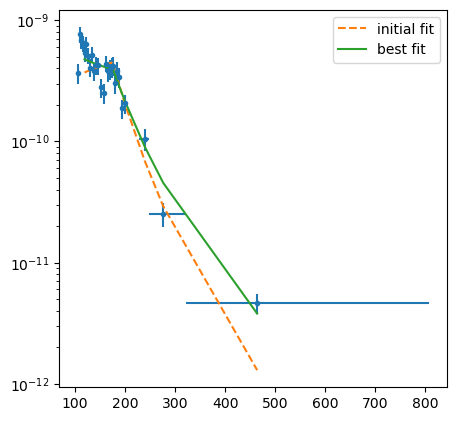

[[Model]]
    Model(broken_power_law)
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 1925
    # data points      = 23
    # variables        = 4
    chi-square         = 1.0762e-19
    reduced chi-square = 5.6641e-21
    Akaike info crit   = -1068.65759
    Bayesian info crit = -1064.11561
[[Variables]]
    t_break:    176.121877 +/- 7.30142469 (4.15%) (init = 175)
    alpha_1:    0.49994585 +/- 0.00504490 (1.01%) (init = -0.5)
    alpha_2:    4.78490012 +/- 1.99662785 (41.73%) (init = 6)
    amplitude:  3.9080e-10 +/- 2.1204e-11 (5.43%) (init = 4.5e-10)
[[Correlations]] (unreported correlations are < 0.100)
    C(t_break, alpha_2)   = 0.718
    C(t_break, amplitude) = -0.594
    C(alpha_2, amplitude) = -0.275


In [11]:
i=7
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = [flux_high[i]+flux_low[i] for i in range(len(flux))]

fit_index = 5

bpl_model = lm.Model(broken_power_law)
bpl_model.set_param_hint("t_break", min = 100, max = 300, value = 175)
bpl_model.set_param_hint("alpha_1", min = -5.0, max = 0.5, value = -0.5)
bpl_model.set_param_hint("alpha_2", min = 3.0, max = 9.0, value = 6)
bpl_model.set_param_hint("amplitude", min = 1e-10, max = 1e-9, value = 4.5e-10)
params = bpl_model.make_params()
result = bpl_model.fit(flux[fit_index:], x = time[fit_index:], method="differential_evolution")

fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(time[fit_index:], result.init_fit, '--', label='initial fit')
plt.plot(time[fit_index:], result.best_fit, '-', label='best fit')
plt.yscale("log")
plt.legend()
plt.show()

print(result.fit_report())